# "Introduction to Graph Representation Learning"
## Szkoła letnia AI-Tech 2023
### Autor: Piotr Bielak

![Logotypy sponsorów](../sponsors.png)

In [1]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://data.pyg.org/whl/torch-2.0.0+cu118.html


## 9. Klasyfikacja grafów

Zadanie to jest podobne do klasyfikacji wierzchołków, przy czym tutaj klasa jest przypisana do całego grafu. Przykładem może być klasyfikacja białek (reprezentowanych jako grafy). 

Zbiór grafów dzielimy na zbiór treningowy, walidacyjny oraz testowy i uczymy odpowiedni klasyfikator. Jedynym zagadnieniem, które musimy rozwiązać jest sposób uzyskania wektora reprezentacji dla całego grafu na podstawie wektorów reprezentacji pojedynczych wierzchołków. Będziemy rozważać proste przekształcenia, które będą agregować wektory wierzchołków w jeden wektor opisujacy cały graf:

- uśrednianie (ang. **mean pooling**): $z_\mathcal{G} = \frac{1}{|\mathcal{V}|} \sum_{u \in \mathcal{V}} z_u$
- redukcja max (ang. **max pooling**): $z_\mathcal{G} = \max_i \{z_1^{(i)}, z_2^{(i)}, \ldots, z_{|\mathcal{V}|}^{(i)} \} \;\forall i = 1 \ldots d$, gdzie $z_u^{(i)}$ oznacza $i$-ty element wektora $z_u$,
- sumowanie: $z_\mathcal{G} =\sum_{u \in \mathcal{V}} z_u$

oraz podejście oparte o architekturę DeepSets.

In [2]:
import torch

torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

Jako zbioru do zadania klasyfikacji grafów użyjemy wprowadzonego wcześniej zbioru **ENZYMES**, który jest zbiorem cząsteczek chemicznych.

In [4]:
from torch_geometric.datasets import TUDataset


dataset = TUDataset(root="/tmp/ENZYMES/", name="ENZYMES", use_node_attr=True)

len(dataset)

600

Podzielimy zbiór teraz na podzbiór treningowy, walidacyjny i testowy oraz wykorzystamy klasę `DataLoader` do utworzenia mini paczek:

In [5]:
from sklearn.model_selection import train_test_split


indices = torch.arange(len(dataset))
y = torch.cat([data.y for data in dataset])


train_idx, rest_idx = train_test_split(indices, train_size=0.5, stratify=y)
val_idx, test_idx = train_test_split(rest_idx, train_size=0.2, stratify=y[rest_idx])


print(f"Train: {len(train_idx) / len(dataset)}")
print(f"Val: {len(val_idx) / len(dataset)}")
print(f"Test: {len(test_idx) / len(dataset)}")

Train: 0.5
Val: 0.1
Test: 0.4


In [6]:
from torch_geometric.loader import DataLoader


batch_size = 32


train_loader = DataLoader(dataset[train_idx], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_idx], batch_size=batch_size)
test_loader = DataLoader(dataset[test_idx], batch_size=batch_size)

In [7]:
batch = next(iter(train_loader))


batch

DataBatch(edge_index=[2, 4118], x=[1069, 21], y=[32], batch=[1069], ptr=[33])

In [8]:
batch.batch

tensor([ 0,  0,  0,  ..., 31, 31, 31])

**Uwaga:** Pole `batch` określa który wierzchołek należy do którego grafu, dzięki czemu jesteśmy w stanie odróżnić kilka grafów zapisanych w jednym obiekcie typu `Data(...)`.

Wykorzystamy teraz gotowe moduły pozwalające na zamianę reprezentacji wierzchołków na reprezentacje grafów, aby zaimplementować model do klasyfikacji grafów:

In [9]:
from torch import nn
from torch.nn import functional as F
from torch_geometric.nn import (
    global_mean_pool,
    global_max_pool,
    global_add_pool,
    DeepSetsAggregation,
)


class GraphClassificationModel(nn.Module):
    
    def __init__(
        self,
        gnn: nn.Module,
        emb_dim: int,
        num_classes: int,
        graph_pooling: str,
    ):
        super().__init__()
        
        self.gnn = gnn
        self.clf_head = nn.Linear(emb_dim, num_classes)
        
        if graph_pooling == "mean":
            self.pooling = global_mean_pool
        elif graph_pooling == "max":
            self.pooling = global_max_pool
        elif graph_pooling == "sum":
            self.pooling = global_add_pool
        elif graph_pooling == "deepsets":
            self.pooling = DeepSetsAggregation()
            
    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        batch: torch.Tensor,
    ) -> torch.Tensor:
        z = self.gnn(x=x, edge_index=edge_index)
        z_graph = self.pooling(z, batch)
        out = self.clf_head(z_graph)
        return F.log_softmax(out, dim=-1)

Wykorzystując również standardową pętlę uczenia w PyTorchu oraz funkcję entropii krzyżowej możemy nauczyć model klasyfikacji grafów:

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from umap import UMAP
from tqdm.auto import trange


def train(model: nn.Module, num_epochs: int):
    losses = {"train": []}
    f1s = {"train": [], "val": [], "test": []}
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
        weight_decay=5e-4,
    )
    
    model = model.to(device)
    
    for epoch in trange(num_epochs, desc="Epochs"):
        # Train
        model.train()
        
        total_loss = 0
        for data_batch in train_loader:
            data_batch = data_batch.to(device)
            
            optimizer.zero_grad()
            
            loss = F.nll_loss(
                input=model(
                    data_batch.x,
                    data_batch.edge_index,
                    data_batch.batch,
                ),
                target=data_batch.y,
            )
        
            loss.backward()
            optimizer.step()
            
            total_loss += float(loss) * data_batch.num_graphs
            
        total_loss /= len(train_loader.dataset)
        losses["train"].append(total_loss)
        
        # Log
        model.eval()
        
        for name, loader in (
            ("train", train_loader),
            ("val", val_loader),
            ("test", test_loader),
        ):
            y_score, y_true = [], []
            
            for data_batch in loader:
                data_batch = data_batch.to(device)
                
                with torch.no_grad():
                    y_score.append(
                        model(
                            data_batch.x,
                            data_batch.edge_index,
                            data_batch.batch,
                        )
                    )
                    y_true.append(data_batch.y)
                
            y_pred = torch.cat(y_score, dim=0).argmax(dim=-1).cpu()
            y_true = torch.cat(y_true, dim=0).cpu()
        
            f1s[name].append(
                f1_score(
                    y_pred=y_pred,
                    y_true=y_true,
                    average="macro",
                )
            )
                
    # Visualize metrics
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    axs = axs.ravel()
    axs[0].plot(range(num_epochs), losses["train"], label="Train")
    axs[0].set(title="Loss")
    axs[0].legend()
    
    axs[1].plot(range(num_epochs), f1s["train"], label="Train")
    axs[1].plot(range(num_epochs), f1s["val"], label="Val")
    axs[1].plot(range(num_epochs), f1s["test"], label="Test")
    best_val_f1 = max(f1s["val"])
    best_idx = f1s["val"].index(best_val_f1)
    best_test_f1 = f1s["test"][best_idx]
    
    axs[1].set(title=f"F1 (best val: {best_val_f1:.4f}, test: {best_test_f1:.4f})")
    axs[1].legend()
    
    # Visualize final embeddings
    graph_embeddings, labels = [], []
    
    for data_batch in DataLoader(dataset):
        data_batch = data_batch.to(device)
        
        with torch.no_grad():
            z = model.gnn(data_batch.x, data_batch.edge_index)
            graph_embeddings.append(model.pooling(z, data_batch.batch).cpu())
            labels.append(data_batch.y.cpu())
            
    graph_embeddings = torch.cat(graph_embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
        
    z2d_pca = PCA(n_components=2).fit_transform(graph_embeddings)
    z2d_umap = UMAP(n_components=2).fit_transform(graph_embeddings)

    sns.scatterplot(
        x=z2d_pca[:, 0],
        y=z2d_pca[:, 1],
        hue=labels,
        palette="Set2",
        ax=axs[2],
    )
    axs[2].set(title="PCA")

    sns.scatterplot(
        x=z2d_umap[:, 0],
        y=z2d_umap[:, 1],
        hue=labels,
        palette="Set2",
        ax=axs[3],
    )
    axs[3].set(title="UMAP")

/home/pbielak/ai_tech_summer_school_graph_intro/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pbielak/ai_tech_summer_school_graph_intro/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pbielak/ai_tech_summer_sch

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

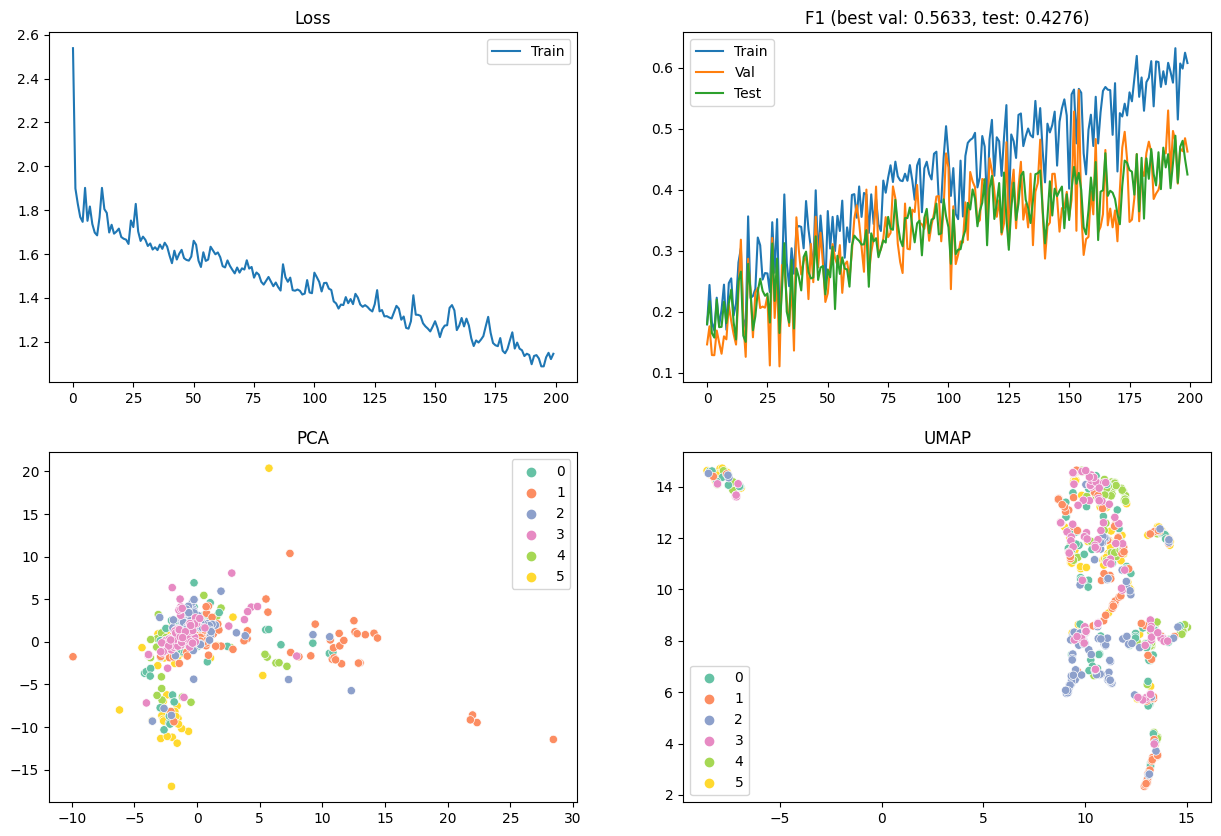

In [19]:
from torch_geometric.nn import GCN


train(
    model=GraphClassificationModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        emb_dim=128,
        num_classes=dataset.num_classes,
        graph_pooling="mean",
    ),
    num_epochs=200,
)

## Zadanie (10 min)

## Z.4. Ewaluacja innych sposobów wyznaczania reprezentacji grafów

Korzystając z powyższego kodu dokonaj ewaluacji i porównania jakości działania innych metod agregacji reprezentacji wierzchołków w reprezentacje grafowe.

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

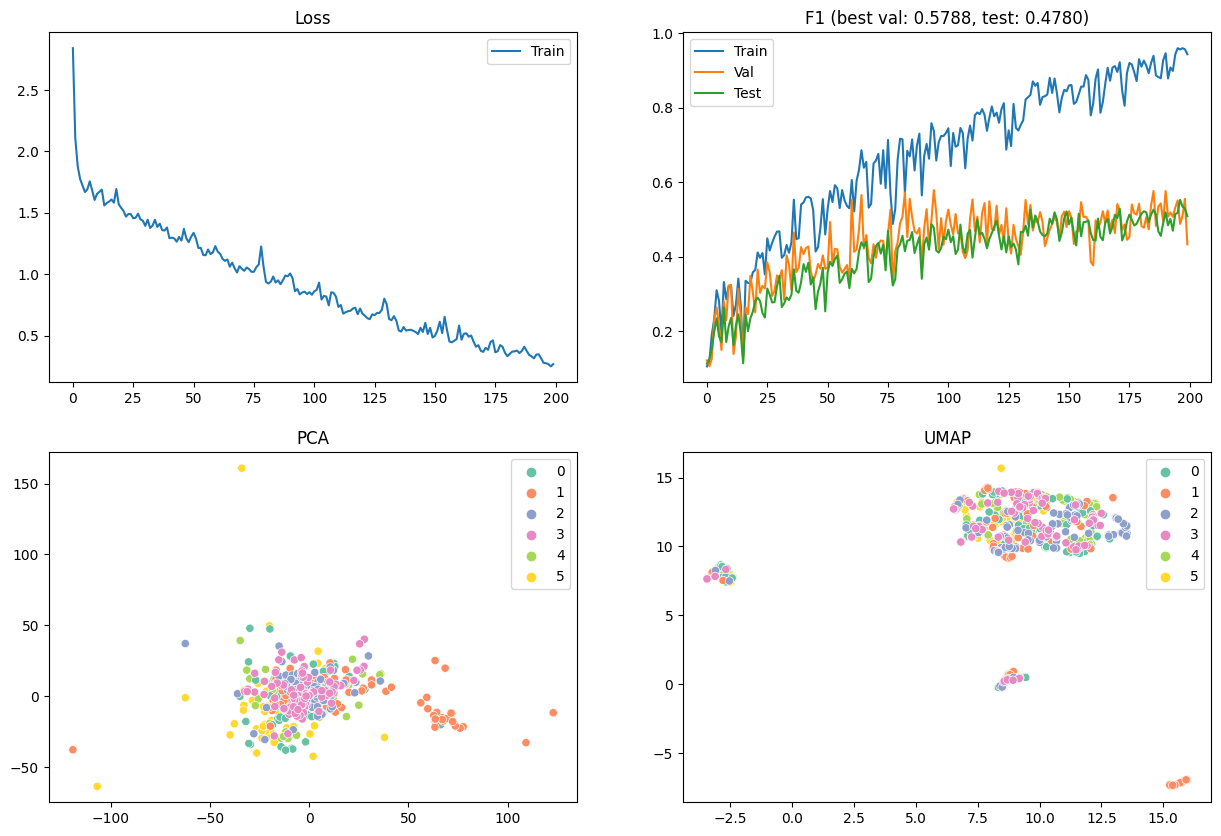

In [16]:
train(
    model=GraphClassificationModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        emb_dim=128,
        num_classes=dataset.num_classes,
        graph_pooling="max",
    ),
    num_epochs=200,
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

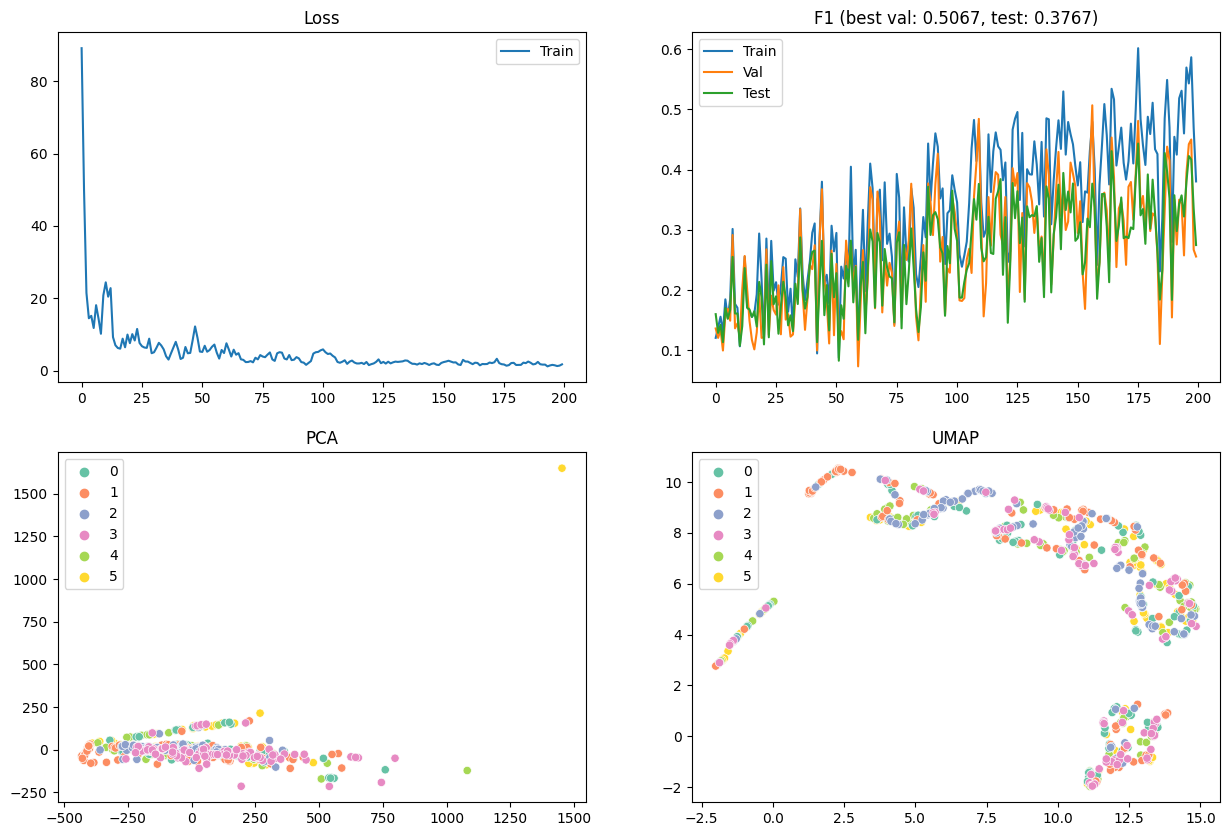

In [17]:
train(
    model=GraphClassificationModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        emb_dim=128,
        num_classes=dataset.num_classes,
        graph_pooling="sum",
    ),
    num_epochs=200,
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

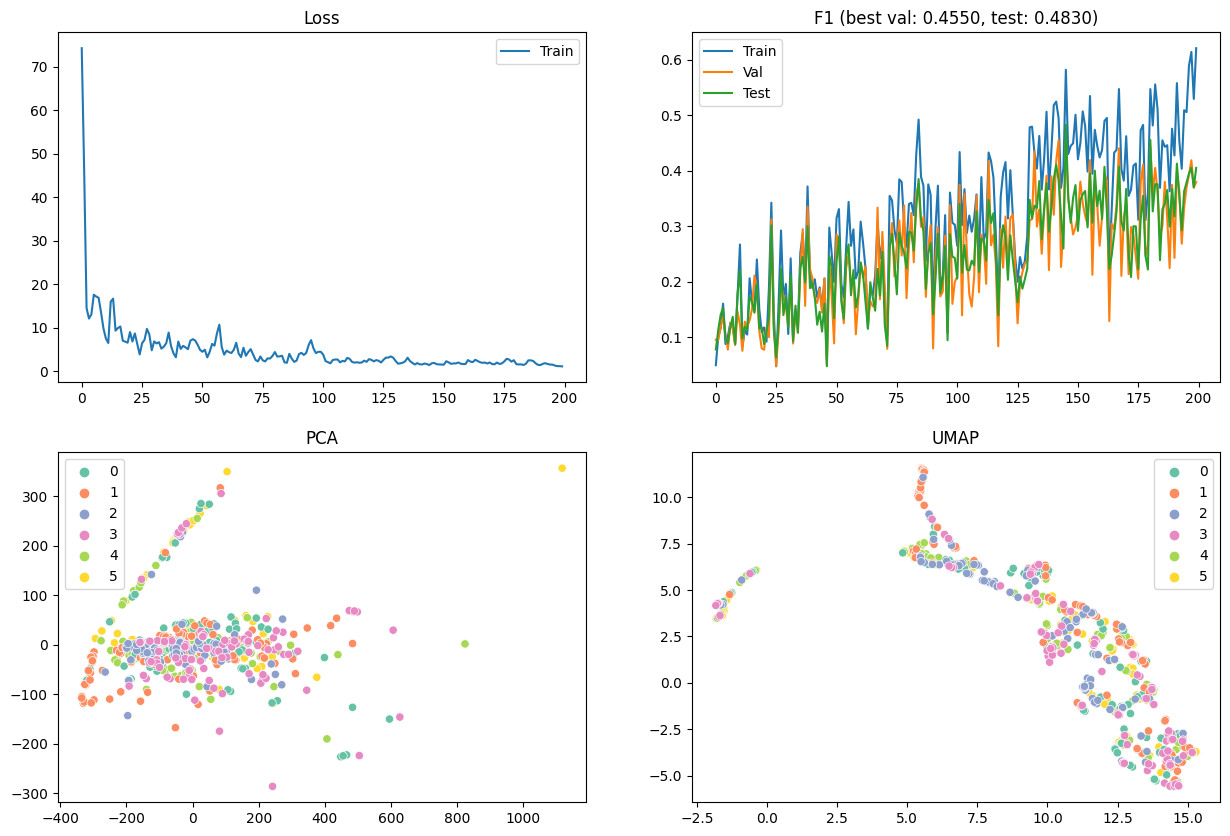

In [18]:
train(
    model=GraphClassificationModel(
        gnn=GCN(
            in_channels=dataset.num_node_features,
            hidden_channels=256,
            out_channels=128,
            num_layers=2,
            act="relu",
        ),
        emb_dim=128,
        num_classes=dataset.num_classes,
        graph_pooling="deepsets",
    ),
    num_epochs=200,
)